# GROWTH Winter School 2018
http://growth.caltech.edu/growth-winter-school-2018.html

# Image subtraction module
Created by: <br > 
Igor Andreoni - andreoni@caltech.edu <br >
Christoffer Fremling - fremling@caltech.edu

## Objective
Learn how to perform image subtraction to discover astronomical transients.

## Key steps
- Register science and reference images (make them aligned and of the same size)
- PSF extraction, using PSFex
- PSF matching by convolution
- [Zero-point calibration]
- Image subtraction

## Required software (in Docker)
 Python 3 (with astropy)   <br />
 
 The following packages are part of AstrOmatic software suite by E. Bertin  https://www.astromatic.net/software <br />
 SWarp  version 2.38.0 (2014-12-09) <br />
 SExtractor  version 2.8.6 (2014-01-16) <br />
 PSFex <br >
 
 ### Important note: visualization with ds9
 
 This notebook includes some commands that call the SAOImageDS9 software (ds9) to display fits files.  The current version of the Docker does not allow to open ds9 displays (or other types of displays) unless the user sets up XQuartz or similar packages. <br >
 
Images generated in this module should be accessible from outside the Docker image, allowing the user to open them using a version of ds9 locally installed.  <br >

SaoImageDS9: http://ds9.si.edu/site/Home.html 

In [1]:
#Import the relevant packages
import numpy as np
from astropy.io import fits #FITS files handling
import os  #Call commands from outside Python
from astropy.io import ascii  #Read/write ascii files
#Useful to smooth the images with a Gaussian kernel before the subtraction
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve 
from astropy.convolution import Gaussian2DKernel
from astropy.stats import sigma_clipped_stats

#Plot
import matplotlib.pyplot as plt



## Reference and science images

Define the reference and science images. Open them with ds9 to give them a look. <br />
Also, what is the size of the images in pixel?  This information will be useful when we want to align the images using Swarp.

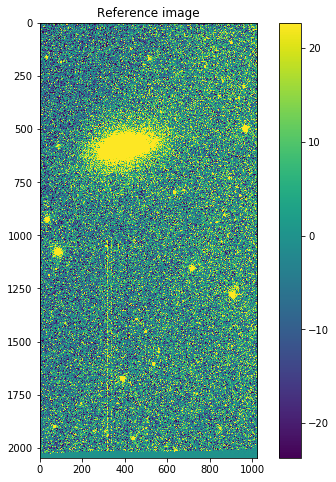

The dimension of the X axis of the reference image is 
1024
The dimension of the Y axis of the reference image is 
2048


In [2]:
os.system("rm *.fits out/*fits") # remove temporary fits files

#Reference image
#ref_image_name='/app/data/image_subtraction/images_subtraction/2014_i_band.fits'
ref_image_name='../../data/image_subtraction/images_subtraction/refimg_i.fits'
#ref_image_name='images_subtraction/2014_i_band.fits'
ref_image = fits.open(ref_image_name)


#Plot up the reference image
mean, median, std = sigma_clipped_stats(ref_image[0].data)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(ref_image[0].data, vmin = median - 2*std, vmax = median + 2*std)
plt.colorbar()
plt.title('Reference image')
plt.show()

#Image size?
print("The dimension of the X axis of the reference image is ")
print(ref_image[0].header["NAXIS1"])
print("The dimension of the Y axis of the reference image is ")
print(ref_image[0].header["NAXIS2"])


#### TASK: 
Let's do the same for the science image.  Can you already spot the Supernova? 

In [1]:
#Science image
sci_image_name='/app/data/image_subtraction/images_subtraction/20120419094409p.fits'
sci_image_name='../../data/image_subtraction/images_subtraction/20120419094409p.fits'
sci_image = ...

#Plot up the science image
...

#Image size?
...


Not yet time to see the supernova in this type of plot (maybe with the appropriate scaling using ds9 you can!), but image-subtraction techniques help you making transients stand out from host galaxies and non-variable sources.

## Align the images

Use the AstrOmatic Swarp package to align the images.  Swarp relies on the astrometric information of the image (in other words, on the sky coordinates), therefore both the science and reference images must be astrometrically calibrated (for example, using the AstrOmatic SCAMP package).  In this module we assume that the input images are already calibrated.

In [4]:
#Assign the commands to a variable
swarp_path="SWarp "

#Swarp command
swarp_command=swarp_path+" "+sci_image_name+" "+ref_image_name+ " -c config.swarp -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR '/app/notebooks/image_subtraction/images_subtraction/out' -COMBINE N -IMAGE_SIZE '1800,900'"

print("The command that you are giving to 'swarp' the images is:")
print(swarp_command)
status=os.system(swarp_command)
print(status)

#Names of the aligned images
sci_image_aligned_name=sci_image_name.replace(".fits", ".resamp.fits")
ref_image_aligned_name=ref_image_name.replace(".fits", ".resamp.fits")



The command that you are giving to 'swarp' the images is:
SWarp  ../../data/image_subtraction/images_subtraction/20120419094409p.fits ../../data/image_subtraction/images_subtraction/2014_i_band.fits -c config.swarp -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR '/app/notebooks/image_subtraction/images_subtraction/out' -COMBINE N -IMAGE_SIZE '1800,900'
256


If we attempt an image subtraction now, what does the result look like? <br >
#### TASK:  
Subtract the reference image from the science image.  Write the result in a fits file.  

In [1]:
#Test image subtraction:
ref_image_aligned=fits.open(ref_image_aligned_name)
sci_image_aligned=fits.open(sci_image_aligned_name)
image_sub = ...

NameError: name 'fits' is not defined

In [6]:
#Visualize with ds9
#os.system('ds9 -zscale '+sci_image_aligned_name +' ' + ref_image_aligned_name + ' sub_test_0.fits &')

# Background Subtraction
- Use 3 sigma clipping, 5 iterations to filter data and accurately measure the backgorund
- Then split image into 200x200 pixel boxes and apply 6x6 median filter

In [7]:
# Background subtraction.  Import the relevant packages
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground
os.system("rm out/bg_sub_test_sci.fits out/bg_sub_test_ref.fits") # remove temporary fits files

#Calculate the background
sigma_clip = SigmaClip(sigma=3., iters=5) # Sigma clipping
bkg_estimator = MedianBackground()
bkg_sci = Background2D(sci_image_aligned[0].data, (200, 200), filter_size=(6, 6), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
bkg_ref = Background2D(ref_image_aligned[0].data, (200, 200), filter_size=(6, 6), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

#Remove the background from the science image
sci_image_aligned[0].data = sci_image_aligned[0].data-bkg_sci.background
hdu_image_sub=fits.PrimaryHDU(bkg_sci.background)
hdu_image_sub.writeto("out/bg_sub_test_sci.fits")

#Remove the background from the reference image
ref_image_aligned[0].data = ref_image_aligned[0].data-bkg_ref.background
hdu_image_sub=fits.PrimaryHDU(bkg_ref.background)
hdu_image_sub.writeto("out/bg_sub_test_ref.fits")


What do the backgorund-subtracted images look like?

In [3]:
#Display with ds9
os.system('ds9 -zscale out/bg_sub_test_sci.fits out/bg_sub_test_ref.fits &')

#Or plot here
plt.imshow(bkg_sci.background, origin='lower', cmap='Greys_r')
#plt.imshow(sci_image_aligned[0].data-bkg_sci.background, origin='lower', cmap='Greys_r')

## PSF matching

The atmosphere heavily affects the PSF of the images by determining the "seeing" conditions. The seeing for ground-based optical telescopes is usually measured as the FWHM of the imaging PSF.  Properties of the atmosphere can change very rapidly, so it is rare that science and reference images are characterized by the same seeing. Therefore their PSFs are usually different, which is a problem for image subtraction. 


### Generate the kernel for the convolution

The PSF of the science and reference images can be matched in several different ways.  Here we start by performing a first source extraction on both the science image.  We can use the catalogs of sources that we obtain for two main purposes: <br />
1. Measure the PSF of the science frame, using PSFex or photutils
2. Obtain instruments magnitudes that will be the basis for the zero-point calibration (see Photometry module).  

In [9]:
#SExtractor command for the science image
sex_path="sextractor "  #Assign the command to a variable in string format

os.system("rm prepsfex.cat") #Remove possible temporary files

#Define the full SExtractor command
sextractor_command=sex_path+" "+sci_image_aligned_name+ \
" -c prepsfex.sex -CATALOG_NAME prepsfex.cat -MAG_ZEROPOINT 25.0"

#Run SExtractor on the science image
os.system(sextractor_command)


0

Now we use another software part of the AstrOmatic suite, PSFex, to measure the PSF of the science image. PSFex estimates the PSF based on the information present in the catalog generated with SExtractor.  Then, let's plot the PSF model obtained with PSFex

In [4]:
#Run PSFex to compute PSF, read and display the final model 
os.system("rm out/proto_prepsfex.fits")
os.system("psfex prepsfex.cat -c psfex_conf.psfex")

psf_sci_image_name='out/proto_prepsfex.fits'
psf_sci_image = fits.open(psf_sci_image_name)

plt.imshow(psf_sci_image[0].data[0], cmap='gray')


### Convolve the reference image with the PSF of the science image
Now that the kernel is generated, let's convolve the reference image with the PSF of the science frame.  

In [11]:
#Convolve the reference image with the PSF of the science frame
os.system("rm ref_convolved.fits")

kernel_sci = psf_sci_image[0].data[0]
ref_image_aligned=fits.open(ref_image_aligned_name)
ref_conv = scipy_convolve(ref_image_aligned[0].data, kernel_sci, mode='same', method='fft')

#Create a new fits file for the convolved image
hdu_ref_conv = fits.PrimaryHDU(ref_conv)
hdu_ref_conv.writeto("ref_convolved.fits")

#Plot up the convolved reference image
mean, median, std = sigma_clipped_stats(hdu_ref_conv.data)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(hdu_ref_conv.data, vmin = median - 2*std, vmax = median + 2*std)
plt.colorbar()
plt.title('Convolved science image')
plt.show()


### Convolve the science image with the PSF of the reference image

#### TASK:
Same as above, but this time we generate a kernel with the properties of the PSF of the reference image.  Then, we convolve the science image with this kernel.

In [12]:
#SExtractor command for the ref image
os.system("rm prepsfex.cat")

sextractor_command=...

#Run SExtractor on the science image
...



0

In [5]:
#Run PSFex to compute PSF, read and display the final model 
os.system("rm out/proto_prepsfex.fits")

os.system("psfex ....")

#Plot the PSF model
...

Ellipsis

In [14]:
#Convolve the reference image the PSF of the science image


os.system("rm sci_convolved.fits")
kernel_ref = ...

# Read the SCIENCE image and convolve it with the PSF of the reference frame
...

#Create a new fits file for the convolved image
hdu_sci_conv = fits.PrimaryHDU(sci_conv)
hdu_sci_conv.writeto("sci_convolved.fits")

#Plot up the convolved reference image


### Improving the alignment
Now that the science image is convolved with (an approximation of) the PSF of the reference image, 
and the reference image is convolved with the PSF of the science image, we can perform the image subtraction.

- Before the subtraction we use an fft method (chi_2_shift) to fine-tune the image alignment of the reference and science image

In [15]:
#Test image subtraction:
os.system("rm sub_test.fits")

from image_registration import chi2_shift
from image_registration.fft_tools import shift
import scipy
from scipy import ndimage, misc
import matplotlib.pyplot as plt
import numpy.fft

# Fine tuning of image alignment
xoff, yoff, exoff, eyoff = chi2_shift(ref_image_aligned[0].data, sci_conv, 10, return_error=True, upsample_factor='auto')
print(xoff,yoff)

sci_conv_shift=scipy.ndimage.shift(sci_conv, [-yoff, -xoff], order=3, mode='reflect', cval=0.0, prefilter=True)



/usr/local/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/usr/local/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = kernel
/usr/local/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:325: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

0.681640625 0.150390625


## Normalization of the images

The science and reference images are usually obtained with different exposure times.  In addition, the reference image can be the stack of several images to increase the depth.  Finally, different CCDs of the same camera (or even different regions of the same CCD when multiple amplifiers are present) may have slightly different gain. <br >

The background subtraction should have removed the non-linear offsets between science and reference images.  We can therefore normalize the two images by computing the ratio of bright star fluxes in the two images. Once again, we use SExtractor to extract the flux and other quantities.

In [24]:
# Normalize images using the stars in the image

os.system("rm prepsfex.cat")
sextractor_command=sex_path+" "+sci_image_aligned_name+ \
" -c prepsfex.sex -CATALOG_NAME sci_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD"

#Run SExtractor on the science image
os.system(sextractor_command)
cat_sci=ascii.read('sci_match.cat')
#print(cat_sci['MAG_AUTO'],cat_sci['X_IMAGE'],cat_sci['Y_IMAGE'])

os.system("rm prepsfex.cat")
sextractor_command=sex_path+" "+ref_image_aligned_name+ \
" -c prepsfex.sex -CATALOG_NAME ref_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD"

#Run SExtractor on the reference image
os.system(sextractor_command)
cat_ref=ascii.read('ref_match.cat')

from astropy.coordinates import SkyCoord
from astropy import units as u
c1 = SkyCoord(ra=cat_sci['X_WORLD'], dec=cat_sci['Y_WORLD'])
c2 = SkyCoord(ra=cat_ref['X_WORLD'], dec=cat_ref['Y_WORLD'])

#print(c1)
idx, d2d, d3d = c1.match_to_catalog_3d(c2)

index_arr=[]
ratio_arr=[]
for i, i2, d in zip(idx, np.arange(len(d2d)),d2d):
    #print(i,d)
    index_arr.append(i)
    print(cat_ref['X_IMAGE'][i],cat_ref['Y_IMAGE'][i],'  ', cat_sci['X_IMAGE'][i2],cat_sci['Y_IMAGE'][i2])
    print(cat_ref['FLUX_AUTO'][i], cat_sci['FLUX_AUTO'][i2]   )
    ratio_arr.append(cat_ref['FLUX_AUTO'][i]/ cat_sci['FLUX_AUTO'][i2] )
    
scale=np.median(ratio_arr)
print(ratio_arr)
print("The scale is", scale)

    

1306.6062 332.7497    1307.3525 331.3415
2129612.0 2147732.0
1324.8009 20.2982    1326.1348 19.8667
8378.608 10737.06
485.4963 21.0009    486.6581 20.3775
1567.076 1923.095
824.3859 3.2165    825.5665 2.9869
449801.7 440552.5
100.8736 858.1496    100.6549 857.7604
3485.942 3547.715
1369.2113 898.5242    1369.3153 898.6678
39900.57 32954.34
1776.3245 854.6361    1776.5719 854.6439
24708.66 24701.16
704.28 855.8884    704.4522 855.6389
3601.638 3998.831
1094.1691 853.0823    1094.4501 852.9572
10022.7 9860.061
590.1396 813.441    623.4059 838.7896
475232.6 2286.396
864.9171 801.4169    941.9843 837.5431
6462.842 1760.752
25.8183 824.1031    25.7729 823.7914
2745.656 3310.109
590.1396 813.441    590.2798 813.4352
475232.6 479266.4
1139.3385 818.3178    1139.6233 818.2759
42746.61 44074.47
1094.1691 853.0823    1096.0933 819.4636
10022.7 1942.716
864.9171 801.4169    865.2281 802.483
6462.842 6485.126
348.4311 800.6634    348.4948 800.7545
5364.201 5701.111
1526.583 788.9504    1526.9297 7

In [16]:
# Perform the subtraction
image_sub = sci_conv_shift*scale-ref_conv

hdu_image_sub=fits.PrimaryHDU(image_sub)
hdu_image_sub.writeto("sub_final.fits")

#Plot up the result of the image subtraction, focusing on the sub-section that includes the host galaxy
mean, median, std = sigma_clipped_stats(hdu_image_sub.data)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(hdu_image_sub.data[200:600,1100:1600], vmin = median - 2*std, vmax = median + 2*std, cmap='gray')
plt.colorbar()
plt.title('Final image subtraction')
plt.show()

#...and plot up the same region of sky of science and template images
mean, median, std = sigma_clipped_stats(sci_conv_shift)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(sci_conv_shift[200:600,1100:1600], vmin = median - 3*std, vmax = median + 3*std, cmap='gray')
plt.colorbar()
plt.title('Science image')
plt.show()

mean, median, std = sigma_clipped_stats(ref_conv)
plt.figure(figsize=(8,8))
#set the scale of the image based on its statistics
plt.imshow(ref_conv[200:600,1100:1600], vmin = median - 3*std, vmax = median + 3*std, cmap='gray')
plt.colorbar()
plt.title('Reference image')
plt.show()




In [25]:
#os.system('ds9 -zscale '+sci_image_aligned_name +' ' + ref_image_aligned_name + ' sub_test.fits &')
os.system('ds9 -zscale sub_test.fits&')

0

There you go, now you should be able to easily spot the supernova as a white excess on the grey background! <br >

Note that the bright center of the host galaxy was not perfectly subtracted and left a spurious signal that could be mistaken for real luminosity variability.  <br >


These operations can be made automatic and can be incorporated in pipelines that discover transients.  Moreover, using the methods learnt in the Photometry module, you can perform forced PSF photometry on the image subtraction to obtain flux measurement of the transient free from the host galaxy contamination.

# END OF THE SCHOOL MODULE


## Bonus:  HOTPANTS

There are some packages that perform most of the operations above automatically.  One of the most popular is called HOTPANTS, which stands for "High Order Transform of PSF ANd Template Subtraction". <br >

The code can be found on GitHub: https://github.com/acbecker/hotpants <br >

The software is not installed on the Docker image provided for the school, but you can install it on your computer and test it using the commands suggested below.



In [19]:
#hotpants
os.system("/Users/chfr1801/Documents/hotpants/hotpants -inim"+" "+sci_image_aligned_name+" "+"-tmplim "+ref_image_aligned_name+" -outim out.fits -oci oci.fits -tg 1 -tr 1 -ig 1 -ir 1 -nrx 1 -nry 1 -nsx 2 -nsy 2 -ng 3 6 0.70 4 1.50 2 3.00 -v 0 -bgo 0 -tl 1 -tu 150000 -il 1 -iu 150000 -ko 0")
#os.system("/Users/chfr1801/Documents/hotpants/hotpants -inim"+" "+sci_image_aligned_name+" "+"-tmplim "+ref_image_aligned_name+" -outim out.fits -oci oci.fits")

hotpants_image = fits.open('oci.fits')
os.system("rm sub_test.fits")
image_sub = hotpants_image[0].data-ref_image_aligned[0].data*0.975
hdu_image_sub=fits.PrimaryHDU(image_sub)
hdu_image_sub.writeto("sub_test.fits")
os.system('ds9 -zscale sub_test.fits &')

32512

## Bonus:  Convolving one image only using fft
We can also perform image subtraction after degrading (i.e., convolving with a kernel) only one of the two images. In fact, in some cases it is preferred to keep the science image untouched and manipulate only the reference to avoid introducing errors in photometry measurements.  On the other hand, convolving both images usually leads to "cleaner" image subtraction.

Below are a list of commands to do a better job with manipulating only one image usinf fft techniques. In this example, we manipulate the science image instead of the reference simply because of what the specific characteristics of the images that we are playing with.  Identical methods can be applied to manipulating reference images only. 

In [ ]:
# alternatively to degrade one image only
Im1_psf=np.fft.fftshift(kernel_ref);
Im2_psf=np.fft.fftshift(kernel_sci);

psf_fft1=np.fft.fft2(Im1_psf);
psf_fft2=np.fft.fft2(Im2_psf);


kern=psf_fft1/psf_fft2;
kern_m=np.real(np.fft.fftshift(np.fft.ifft2(kern)))
kern_mean=np.mean(kern_m)
psf_m=(kern_m/(kern_mean*59*59))

plt.imshow(psf_m, cmap='gray')

sci_conv = scipy_convolve(sci_image_aligned[0].data, psf_m, mode='same', method='fft')

from image_registration import chi2_shift
from image_registration.fft_tools import shift
import scipy
from scipy import ndimage, misc
import matplotlib.pyplot as plt
import numpy.fft

xoff, yoff, exoff, eyoff = chi2_shift(ref_image_aligned[0].data, sci_conv, 10, return_error=True, upsample_factor='auto')
print(xoff,yoff)

sci_conv_shift=scipy.ndimage.shift(sci_conv, [-yoff, -xoff], order=3, mode='reflect', cval=0.0, prefilter=True)
                 
os.system("rm sub_test2.fits")
image_sub = sci_conv_shift-ref_image_aligned[0].data
hdu_image_sub=fits.PrimaryHDU(image_sub)
hdu_image_sub.writeto("sub_test2.fits")

os.system('ds9 -zscale sub_test2.fits&')